Описание содержания проекта по разработке сервиса предсказания суточного объема потребления и транспортировки природного газа.

Цель проекта: Разработка сервиса необходима для повышения уровня прогнозирования объемов транспортировки и потребления природного газа с последующим увеличением показателей планово-экономической деятельности.

Описание сервиса: Продукт будет построен на основе ML алгоритма, позволяющего прогнозировать объемы транспортировки и потребления природного газа с точностью выше, чем алгоритм, основанный на расчете средней величины. В качестве данных, на которых будет обучаться модель мы используем датасеты, содержащие информацию о потреблении ПГ за периоды с 2016 по 2019 годы. 

Структура исходных датасетов следующая:
Дата потребления
	Потребитель 1	…Потребитель N	Группа потребителя
Для получения более точных результатов, датасет дополняем следующими «фичами»:
-	признак выходного/праздничного дня;
-	среднесуточная температура;
-	признак отопительного сезона;
-	другие признаки, генерируемые из вышеперечисленных.

Мы будем анализировать две группы потребителей(14 потребителей):
1 группа состоит из двух крупнейших потрбителей газа(около 13% годового потребления ПГ)
2 группа состоит из 12 крупнейших потребителей газа(около 6% годового потребления ПГ)
Всего порядка 10000 потребителей юридических лиц, таким образом рассматриваемые группы потребителей в общей соповкупности составляют 20 % потребления. 

Задачи проекта:
1)	Произвести EDA, FE
2)	Проверить несколько видов алгоритмов машинного обучения (Логистическая регрессия, XGBoost, Sarima, Prophet)
3)	Получить лучшее метрики в сравнении с расчетом средней величины. Используемые метрики : MAE, MAPE, R2
4)	Разработка модели в продакшн.


Что будем делать.
В процессе будем пробовать два типа алгоритмов: методы анализа временных рядом(Sarima, Prophet), метод машинного обучения XGBoost(в том числе на временном ряду приведенным к стационарному виду)   

In [4]:
#pip install --upgrade xgboost


In [3]:
#pip install --upgrade tensorflow

In [2]:
#pip install prophet

In [209]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import math
import xgboost


# Загружаем модуль для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm



import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

#from fbprophet import prophet

# Загружаем соответствующие методы нормализации:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#different statistical models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize

from itertools import product

# Загружаем метод создания полиномаиальных признаков:
from sklearn.preprocessing import PolynomialFeatures

# Загружаем модули для работы с датой и временем
from datetime import datetime
from datetime import timedelta

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler


In [28]:
data = pd.read_excel('DataSet_for_model.xlsx', sheet_name='2') 

## Functions used


In [3]:
#прорисовка Boxplot
def get_boxplot(col):
    fig, ax = plt.subplots(figsize = (20, 14))
    sns.boxplot(y= col, data = data)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)
    plt.show()
    
#удаление выбросов
def cut_emissions(x):
    median = x.median()
    IQR = x.quantile(0.75) - x.quantile(0.25)
    perc25 = x.quantile(0.25)
    perc75 = x.quantile(0.75)
    x = x.loc[x.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    return x

#кросс валидация
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

#MAPE
def MAPE(actual,predicted):
    mape = np.mean(np.abs((actual - predicted)/actual))*100
    return mape

    
    

## EDA

Изучим полученный датасет

In [6]:
data.shape

(1095, 5)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1095 non-null   datetime64[ns]
 1   holiday            1095 non-null   bool          
 2   temp               1095 non-null   float64       
 3   tep_en_5257087027  1095 non-null   float64       
 4   lukoil_5250043567  1095 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(3)
memory usage: 35.4 KB


Проверим дата сет на пропуски

In [5]:
data.isna().sum().sort_values()

date                 0
holiday              0
temp                 0
tep_en_5257087027    0
lukoil_5250043567    0
dtype: int64

Проверка и удаление столбцов с повторяющимимся неинформативными значениями(более 30 значений)

In [19]:
for col in data.columns: 
    if (len(data[col].unique()) < 30): 
        if(col != 'holiday'):
            data = data.drop(col, axis = 'columns')

#### У нас временные ряды,  вероятнее всего не стационарные. Наша задача перед переадчей рядов в модель SARIMA сделать их стационарными. Для этого выделим  наличие трендов и сезонность.

In [ ]:
# проверка рядов на стационарнсоть с помощью теста Дикки-Фуллера
# для начала визщуализируем временные ряды группы потребителей №1

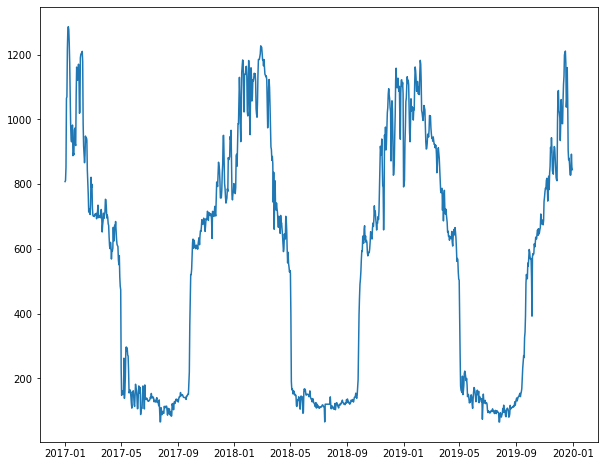

In [40]:
plt.rcParams["figure.figsize"] = 10, 8
plt.plot(data['date'], data['tep_en_5257087027'])
#plt.plot(data['date'], data['lukoil_5250043567'])
plt.show()


In [69]:
data = pd.read_excel('DataSet_for_model.xlsx', sheet_name='2') 

tep_en_5257087027                        
                   mean      median         std
month                                          
1           1033.091726  1039.95150  125.371019
2           1023.524589  1025.18925  137.899031
3            858.932935   810.29500  163.432550
4            634.766583   637.34425   54.079642
5            183.596823   155.03000   89.161367
6            138.691250   137.98500   21.083266
7            110.368581   111.51400   19.613255
8            110.480355   112.50200   14.232480
9            225.855233   146.49200  146.341974
10           630.509548   630.51300   50.310773
11           808.859633   798.50800  108.073570
12           955.541108   950.06400  134.575514

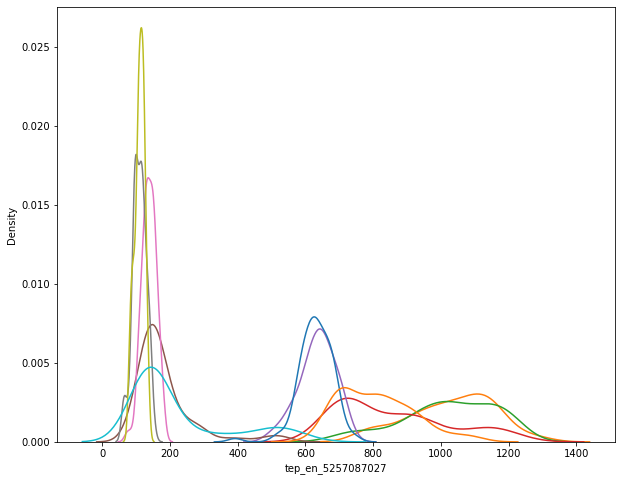

In [47]:
#посомтрим на распределение рядов по дням недели и месяцам
#для этого добавим сначала новые признаки
data['dayofweek'] = data['date'].dt.dayofweek
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month

for i in range(12):
    sns.distplot(data[data['month'] == i]['tep_en_5257087027'], hist = False, label=str(i))
data.groupby('month').agg({'tep_en_5257087027':['mean','median','std']})

In [17]:
#четко прослеживается сезонность и тренд по обоим временным рядам 


## SARIMA

Этот алгоритм создан на базе двух алгоритмов(регрессионый и алгоритм скольящего среднего).Для его работы необходимо подготовить ряд, избавив его от тренда и подобрать параметры.
Попробуем избавиться от сезонности и трендов во временных рядах

ADF Statistic: -1.979227
p-value: 0.295755
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


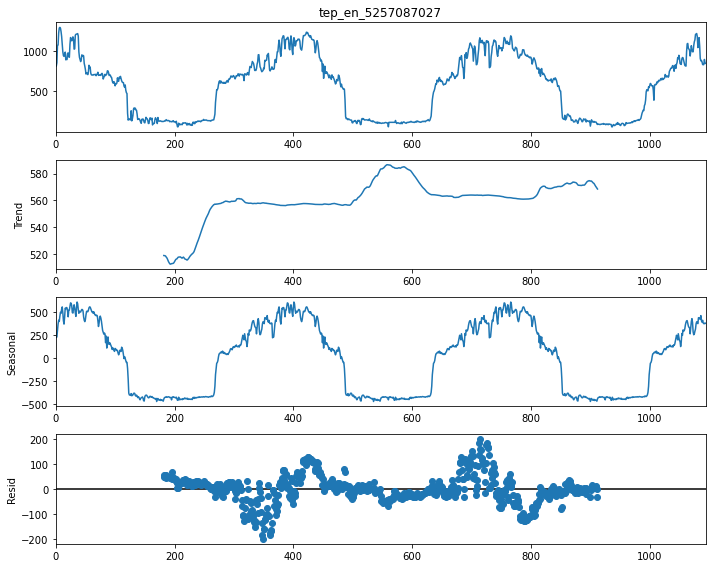

In [48]:
sm.tsa.seasonal_decompose(data['tep_en_5257087027'], freq=365).plot()
result = sm.tsa.stattools.adfuller(data['tep_en_5257087027'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
#adfuller_test(data['tep_en_5257087027'], signif = 0.05, name = 'tep_en_5257087027', verbose = False)


In [49]:
#нулевая гипотеза о нестационарности не отвергается
# сделаем дифференцирование ряда
data['tep_en_5257087027_diff'] = data['tep_en_5257087027'].diff(1)

Критерий Дики-Фуллера: p=0.000000


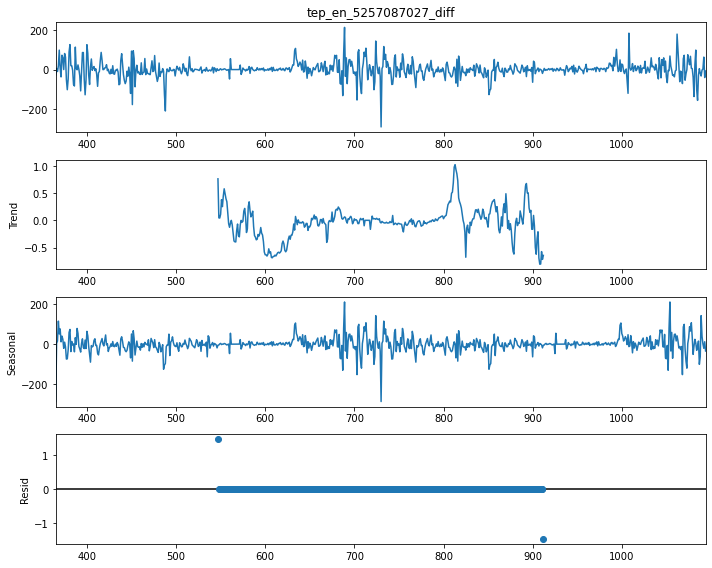

In [52]:
sm.tsa.seasonal_decompose(data['tep_en_5257087027_diff'][365:], freq=365).plot()
print(
    "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['tep_en_5257087027_diff'][365:])[1]
)

Критерий ДФ отвергает нулевую гипотезу и говорит, что ряд стационарный, однако на графиках проглядывается тренд и сезонность, поэтому применим еще раз дифф ряда

Критерий Дики-Фуллера: p=0.000000


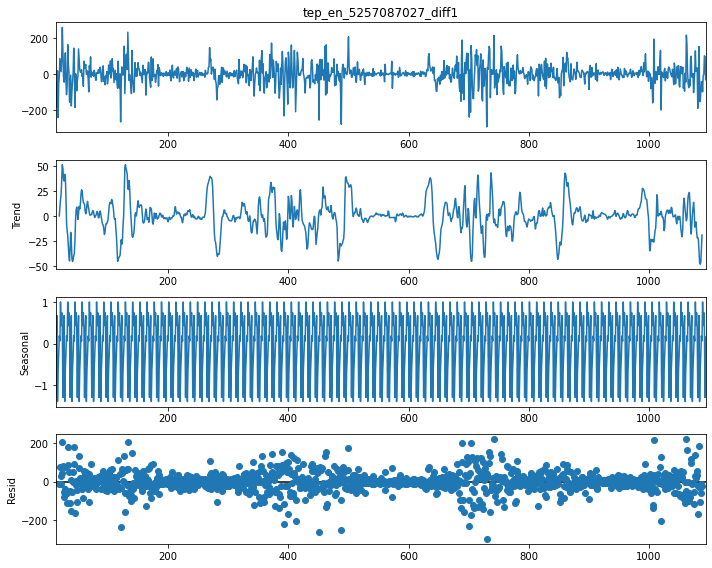

In [33]:
data['tep_en_5257087027_diff1'] = data['tep_en_5257087027_diff'].diff(1)

sm.tsa.seasonal_decompose(data['tep_en_5257087027_diff1'][13:], freq=12).plot()
print(
    "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['tep_en_5257087027_diff1'][13:])[1]
)

Теперь на графике трнеда нет, но сезонность осталась. Значит будем испольщовать модель SARIMA, котороре хорошо работае с временными рядами содержащими сезонность.
Для начала работы подберем следующие параметры для модели SARIMA:

p — порядок модели AR(p)
d — порядок интегрирования исходных данных
q — порядок модели MA(q)
P — порядок сезонной составляющей SAR(P)
D — порядок интегрирования сезонной составляющей
Q — порядок сезонной составляющей SMA(Q)
s — размерность сезонности(в нашем случае месячная сезонность, s = 12)

Есть два способа подбора параметров: Аналитический(рассмотрим только для примера) и автоматический(перебор параметров, на практике будем использовать его). Аналитический способ нам интересен только с точки зрения понимания теории. В данном случае параметры подбираются путем анализа ACF и PACF и  порядком интегрированности сезонной разности/обычной разности(в нашем случае = 2, так как два раза дифференциоравали ряд).

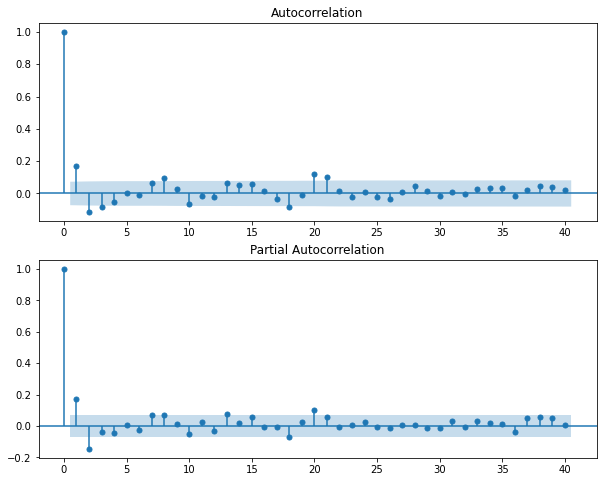

In [54]:
# для примера рассмотрим подбор параметров P,p и Q,q путем анализа ACF и PACF
# посмотрим на ACF и PACF
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(
    data["tep_en_5257087027_diff"][366:].values.squeeze(), lags=40, ax=ax
)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(
    data["tep_en_5257087027_diff"][366:].values.squeeze(), lags=40, ax=ax
);

In [21]:
data["tep_en_5257087027_diff1"] = data["tep_en_5257087027_diff1"].dropna()

мы в видим, что у функции есть не нудевые значения, значит наш временной ряд обладают определенной не стационарностью. Рекомендуемые коэфф для Q,q = 37, P,p = 12

In [63]:
# приступим к подбору параметров для SARIMA с помощью автоматического перебора
# код взять из материалов курса(вэбинар), только увеличим интервалы 

ps = range(0, 5)
d = 1
qs = range(0, 1)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)

# product(*iterables, repeat=1) - аналог вложенных циклов.
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)



In [64]:
%%time
results = []
best_aic = float("inf")


for param in parameters_list:
    # try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(
            data["tep_en_5257087027_diff"],
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12),
        ).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print("wrong parameters:", param)
        continue
    aic = model.aic
    # сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

C:\tmp\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\tmp\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\tmp\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\tmp\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\tmp\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

Wall time: 1h 21min 51s


In [65]:
#лучшие параметры
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
print(result_table.sort_values(by="aic", ascending=True).head())

       parameters           aic
99   (3, 0, 4, 4)     24.000000
104  (4, 0, 0, 4)  11341.881706
116  (4, 0, 3, 1)  11342.305410
121  (4, 0, 4, 1)  11344.218298
103  (4, 0, 0, 3)  11344.435564


Критерий Дики-Фуллера: p=0.997022


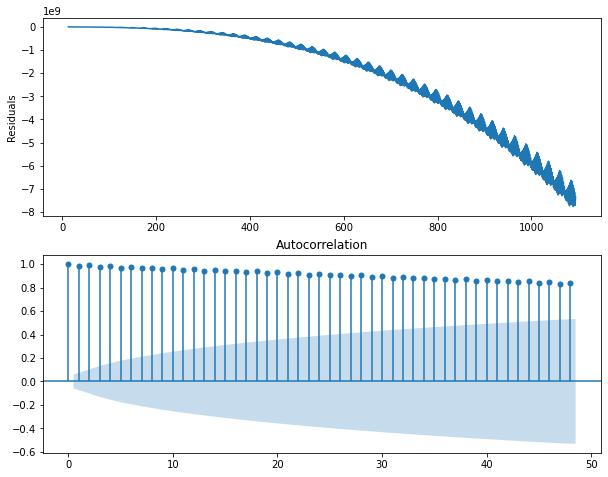

In [66]:
# посмотрим на остатки ряда, в идеале там должен остаться белый шум
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u"Residuals")

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print(
    "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1]
)

Остатки стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

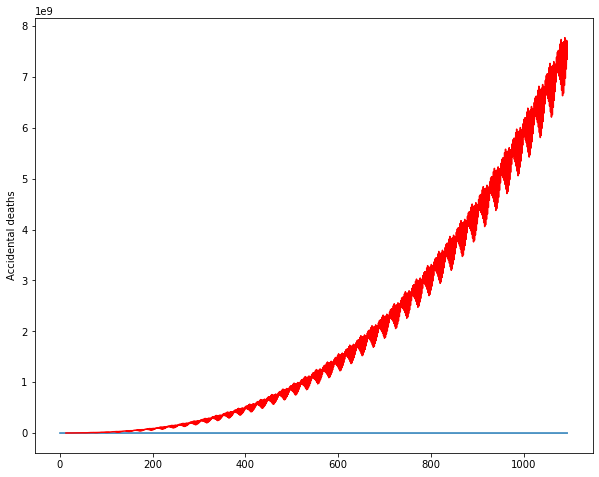

In [67]:
data["model"] = best_model.fittedvalues
data["tep_en_5257087027"].plot()
data["model"][13:].plot(color="r")
plt.ylabel("Accidental deaths");

In [27]:
MAPE(data.tep_en_5257087027,data.model)

99.97412647225022

## XGBoost

Теперь рассмотрим классический класс алгоритов ML - древовидный алгоритм XGBoost. 
В отличие от работы с "классическими" данными, не содержащими временные ряды, в нашем случае необходимо "адаптивное" разбиение выборки на тестовую и валидационную части. ДЛя жтого будем использовать функцию TimeSeriesSplit(). 

## FE

In [64]:
#correlation = data.corr()
#plt.rcParams['figure.figsize'] = (25,15)
#sns.heatmap(correlation, annot = True, cmap = 'coolwarm')

In [71]:
#добавим  новые признаки
data['dayofweek'] = data['date'].dt.dayofweek
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month

In [75]:
data

,tep_en_5257087027,lukoil_5250043567,dayofweek,day,month,season,num_holiday,temperature
0,808.011,734.991,6,1,1,1,1,1.3
1,811.360,724.584,0,2,1,1,1,0.6
2,852.364,760.213,1,3,1,1,1,-4.1
3,1065.322,729.123,2,4,1,1,1,-16.5
4,1070.136,738.825,3,5,1,1,1,-10.8
...,...,...,...,...,...,...,...,...
1090,827.355,611.823,4,27,12,1,0,-7.1
1091,830.114,672.302,5,28,12,1,1,-6.5
1092,892.726,673.892,6,29,12,1,1,-5.3
1093,852.529,616.126,0,30,12,1,0,-5.0


добавим признак отопительного сезона

In [72]:
data['season'] = data['month'].apply(lambda x: 1 if x > 9 else 1 if x < 5 else 2)

оцифруем столбец 'Признак выходного дня'

In [73]:
label_encoder = LabelEncoder()
data['num_holiday'] = pd.Series(label_encoder.fit_transform(data['holiday']))

In [74]:
data['temperature'] = data['temp']
data.drop(['holiday','date','temp'], inplace = True, axis = 1)


## ML

In [133]:
#создадим массив для зависимой переменной
y = data.iloc[:,:-7].values

#создадим массив для переменных-признаков]
X = data.iloc[:,2:].values




In [229]:
model = xgb.XGBRegressor()

parameters = [
    {'kernel': ['rbf'],
     'gamma': [.01],
     'C': [1, 10, 100]}]

model = GridSearchCV(model, param_grid=parameters, scoring='neg_mean_absolute_error', 
                   cv=TimeSeriesSplit(n_splits=7).split(X),verbose = 1)
model.fit(X,y)


y_pred = model.predict(X_test)

from sklearn import metrics  # подгружаем метрики
print('MAE:',metrics.mean_absolute_error(y_test, y_pred),
      'MAPE:', mean_absolute_percentage_error(y_test, y_pred))





Fitting 7 folds for each of 3 candidates, totalling 21 fits
[20:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { C, kernel } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { C, kernel } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { C, kernel } might not be used.

  This may not be 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[20:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { C, kernel } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { C, kernel } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { C, kernel } might not be used.

  This may not be accurate due to some parameters are only used in language b

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    1.5s finished


In [226]:
# Create the time series split generator
tscv = TimeSeriesSplit(n_splits=7)

for train_index, test_index in tqdm(tscv.split(X)):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
   
    # scale the data set
    #scaler_X = StandardScaler()
    #scaler_y = StandardScaler()
    #scaler_X.fit(X_train)
    #scaler_y.fit(y_train)
    #X_train, X_test = scaler_X.transform(X_train), scaler_X.transform(X_test)
    #y_train, y_test = scaler_y.transform(y_train), scaler_y.transform(y_test)


parameters = [
    {'kernel': ['rbf'],
     'gamma': [.01],
     'C': [ 1,10,100,500,1000]}]


model = xgb.XGBRegressor()

for e, g in enumerate(ParameterGrid(parameters)):
    model.set_params(**g)
    model.fit(X_train, y_train)
    score = metrics.mean_absolute_error(model.predict(X_train), y_train)
    if e == 0:
        best_score = score
        best_params = g
    elif score < best_score:
        best_score = score
        best_params = g


# refit the model with the best set of params

model.set_params(**best_params)
model.fit(X_train, y_train)  

y_pred = model.predict(X_test)

from sklearn import metrics  # подгружаем метрики
print('MAE:',metrics.mean_absolute_error(y_test, y_pred),
      'MAPE:', mean_absolute_percentage_error(y_test, y_pred))




7it [00:00, 7002.18it/s]


[19:54:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { C, kernel } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:54:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { C, kernel } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:54:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { C, kernel } might not be used.

  This may not be accurate due to some parameters are only used in language bi

In [82]:
# обучим модель
from sklearn.linear_model import LinearRegression
model_reg = LinearRegression() #Обозначаем, что наша модель - линейная регрессия
model_reg.fit(X_train,y_train) #обучаем модель на обучающих данных


LinearRegression()

In [194]:
trainX

[[1], [2], [3], [4], [5]]

In [191]:
#предскажем значения расходов газа на тестовой выборке
#y_pred = model_reg.predict(X_test)
#y_pred = model_boost.predict(X_test)


In [158]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [192]:
#оценим ошибку предсказанной величины
from sklearn import metrics  # подгружаем метрики
print('MAE:',metrics.mean_absolute_error(y_test, y_pred),
      'MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 61.44628082040639 MAPE: 157.49383667947984


In [193]:
#вычислим коэффициент детерминации
R_2 = metrics.r2_score(y_test, y_pred)
print(R_2)

0.9089076016331837
